In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=4, max_train_size=60, test_size=18) # Train size is 5 years

# Prepare data
## Seperate development and production dataset

In [2]:
ALL_DATA = pd.read_csv("../Data/kitCapstoneJan24_data.csv", delimiter=";")
TARGET_COL_NAME = "sales_actuals_monthly__orderintake"
TEST_INDEX = 258
TEST_PERIOD = 18
ALL_DATA

# DATA_START = 60
# TEST_INDEX = 258 - DATA_START
# TEST_PERIOD = 18
# TARGET_COL_NAME = "sales_actuals_monthly__vehiclegroup01__orderintake"

# PATH_RUN2_DATA = r"../output_data\run2_run_countryA_all_values\run_Country A_all_2337_NaN_fillup.csv"
# PATH_RUN2_F_IMPORTANCE = r"../output_data\run2_run_countryA_all_values\run_Country A_all_2349value_importance_list.csv"

# PATH_RUN3_DATA = r"../output_data/run3_run_countryA_vehicle01_all_values/run_Country A_all_2351_NaN_fillup.csv"
# PATH_RUN3_F_IMPORTANCE = r"../output_data/run3_run_countryA_vehicle01_all_values/run_Country A_all_2352value_importance_list.csv"

,month,countryname,sales_actuals_monthly__vehiclegroup01__orderintake,sales_actuals_monthly__vehiclegroup01__retail,sales_actuals_monthly__vehiclegroup02__orderintake,sales_actuals_monthly__vehiclegroup02__retail,sales_actuals_monthly__vehiclegroup03__orderintake,sales_actuals_monthly__vehiclegroup03__retail,sales_actuals_monthly__vehiclegroup04__orderintake,sales_actuals_monthly__vehiclegroup04__retail,...,registrations__buildtype_suv,registrations__buildtype_transport,registrations__buildtype_van,registrations__buildtype_cabrio,registrations__buildtype_stufenheck,registrations__buildtype_kurzheck,registrations__buildtype_other,registrations__buildtype_pickup,registrations__buildtype_coupe,registrations__buildtype_kombi
0,1,Country A,296.0,352.0,739.0,471.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Country A,414.0,372.0,904.0,528.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Country A,405.0,604.0,1000.0,953.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Country A,359.0,483.0,828.0,972.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Country A,403.0,474.0,594.0,900.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,356,Country D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1436,357,Country D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1437,358,Country D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1438,359,Country D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
def get_data(df, veh_group, country):
    data = df.loc[df["countryname"] == country, :].filter(regex=veh_group)
    data.columns = [col.replace(veh_group + '__', '') for col in data.columns]
    data.reset_index(inplace=True, drop=True)
    data = data.fillna(data.mean()) # Filling with MEAN VALUE!!!!!!! NEED to fix
    dev_set = data.iloc[:TEST_INDEX, :]
    prod_set = data.iloc[:TEST_INDEX + TEST_PERIOD, :] # include features of predicting period (month 259 -> 276)

    print(dev_set.shape)
    print(prod_set.shape)
    return dev_set, prod_set

dev_set, prod_set = get_data(ALL_DATA, "vehiclegroup01", "Country A")

# def get_data_sources(path_data, path_f_importance, num_features):

#     value_importance = pd.read_csv(path_f_importance)
#     data = pd.read_csv(path_data)

#     val_imp = value_importance["Feature"].iloc[:num_features].to_list()
#     train_data = data[val_imp].copy()

#     train_data[TARGET_COL_NAME] =  data[TARGET_COL_NAME].copy()
    
#     print(val_imp)

#     return train_data

# def get_data(data):
#     data_cut = data.iloc[DATA_START:, :]
#     data_cut.reset_index(inplace=True, drop=True)
#     dev_set = data_cut.iloc[:TEST_INDEX, :]
#     prod_set = data_cut.iloc[:TEST_INDEX + TEST_PERIOD, :] # include features of predicting period (month 259 -> 276)

#     print(dev_set.shape)
#     print(prod_set.shape)

#     return dev_set, prod_set

# data = get_data_sources(PATH_RUN3_DATA, PATH_RUN3_F_IMPORTANCE, num_features=35)
# dev_set, prod_set = get_data(data)

(258, 18)
(276, 18)


# Traing and evaluate model
**Goal: Find the best model**

In [4]:
# # Split the development set as "blocks of data" to evaluate the performance of the model
# data_cv = {}
# for i, (train_index, val_index) in enumerate(tscv.split(dev_set)):
#     print(f"Train range {train_index[0]} - {train_index[-1]}, val range {val_index[0]} - {val_index[-1]}")
#     data_cv[i] = {
#         "train": data.iloc[train_index, :], 
#         "val": data.iloc[val_index, :]
#     }

## Define model

In [5]:
from abc import ABC, abstractmethod
from typing import List

class Model(ABC):
    @abstractmethod
    def __init__(self, data_block) -> None:
        """
            data_block: Dictionary of both train and test DataFrame
        """
        self.train_data, self.val_data = data_block["train"], data_block["val"]
        self.y_train = self.train_data.loc[:, TARGET_COL_NAME]
        self.y_val = self.val_data.loc[:, TARGET_COL_NAME]

    @abstractmethod
    def train(self) -> None:
        ...

    @abstractmethod
    def predict(self) -> List[float]:
        ...

    def run_eval(self, verbose=True) -> float:
        print("Training...")
        self.train()

        if self.y_val.isna().any().any():
            raise RuntimeError("No label data to evaluate.")

        print("\nEvaluating...")
        y_true = self.y_val.tolist()
        y_pred = self.predict()
        mape = mean_absolute_percentage_error(y_true, y_pred)

        if verbose:
            plt.figure(figsize=(15,6))
            x_ticks = range(TEST_INDEX, TEST_INDEX+TEST_PERIOD)
            plt.plot(x_ticks, y_true, color="black", label="Truth")
            plt.plot(x_ticks, y_pred, color="red", linestyle="--", label="Predict")
            plt.xticks(x_ticks)
            plt.legend()
            plt.xlabel("Month")
            plt.ylabel("Order intake")
            plt.title(f"MAPE = {mape:.4f}")
            plt.show()
            
        return mape

### ARIMAX

In [6]:
import pmdarima as pm

class SARIMAXModel(Model):
    def __init__(self, data_block, exo=True, predict_periods=TEST_PERIOD):
        super().__init__(data_block)

        self.exogenous_data_train = None
        self.exogenous_data_val = None
        if exo:
            self.exogenous_data_train = self.train_data.drop(TARGET_COL_NAME, axis=1)
            self.exogenous_data_val = self.val_data.drop(TARGET_COL_NAME, axis=1)

        self.model : pm.arima.ARIMA = None
        self.predict_periods = predict_periods

    def train(self):
        # https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html
        # Find the best model using stepwise algorithm outlined in Hyndman and Khandakar (2008)
        self.sarima = pm.auto_arima(y=self.y_train, # target
                                    X=self.exogenous_data_train, # data
                                    start_p=0, max_p=5,
                                    start_q=0, max_q=5, # maximum p and q
                                    start_P=0, max_P=5,
                                    start_Q=0, max_Q=5, 
                                    d=None,              # usual differencing
                                    D=None,              # seasonal differencing
                                    seasonal=True,   # Seasonality
                                    m=12,              # frequency of series
                                    test='adf',       # use adftest to find optimal 'd'
                                    trace=True,
                                    error_action='ignore',  
                                    suppress_warnings=True,
                                    scoring='mse', # mae/mse
                                    stepwise=True)

    def predict(self):
        y_predict = self.sarima.predict(n_periods=self.predict_periods, X=self.exogenous_data_val).tolist()
        return y_predict

# SARIMAX_model = SARIMAXModel(data_cv[0], exo=False)
# SARIMAX_model.run_eval()

### XGBoost

In [7]:
import xgboost

class XGBoostModel(Model):

    x_train = []
    y_train = []

    def __init__(self, data_block):
        super().__init__(data_block)
        self.preprocessing()
        self.model = xgboost.XGBRegressor(use_label_encoder=False, eval_metric="mape")

    def preprocessing(self):
        """Main idea: Use past input data to predict future target value
            For target value:
                - Val: No change
                - Train: Don't use the first {TEST_PERIOD} months of target train
            For input data:
                - Train: Don't use the last {TEST_PERIOD} months of input data train
                - Val: Use the last {TEST_PERIOD} months of input data train
        """
        print("\nPreprocessing data...")
        self.y_train = self.y_train.iloc[TEST_PERIOD:]
        self.X_train = self.train_data.drop(TARGET_COL_NAME, axis=1).iloc[:-TEST_PERIOD, :]
        self.X_val = self.train_data.drop(TARGET_COL_NAME, axis=1).iloc[-TEST_PERIOD:, :]

    def train(self):
        tscv = TimeSeriesSplit(n_splits=10)
        for _, (train_index, val_index) in enumerate(tscv.split(self.X_train)):
            train_fold = self.X_train.iloc[train_index, :]
            test_fold = self.y_train.iloc[train_index]
            self.model.fit(train_fold, test_fold)

    def predict(self):
        prediction = self.model.predict(self.X_val).tolist()
        return prediction
    
# XGBoost_model = XGBoostModel(data_cv[0])
# XGBoost_model.run_eval()

### Prophet

In [8]:
from prophet import Prophet

class ProphetModel(Model):
    def __init__(self, data_block, predict_periods=TEST_PERIOD) -> None:
        super().__init__(data_block)
        self.preprocessing()
        self.model = Prophet(yearly_seasonality=True)
        self.predict_periods = predict_periods

    def preprocessing(self):
        """Expect to have at least 2 columns 'ds' (YYYY-MM-DD) and 'y'
            https://facebook.github.io/prophet/docs/quick_start.html#python-api    
        """
        print("\nPreprocessing data...")
        self.y_train = self.y_train.reset_index(drop=True)
        self.y_train = pd.DataFrame({'ds': range(len(self.y_train)), 'y': self.y_train.values})
        start_date = '2000-01-01'  # Adjust this date to your needs
        self.y_train['ds'] = pd.to_datetime(self.y_train['ds'].apply(lambda x: pd.DateOffset(months=x) + pd.Timestamp(start_date)))

    def train(self):
        self.model.fit(self.y_train) 

    def predict(self):
        future = self.model.make_future_dataframe(periods=self.predict_periods, freq = "MS")
        forecast = self.model.predict(future)
        predict = forecast.loc[len(self.y_train):, 'yhat'].tolist()
        return predict

# prophet_model = ProphetModel(data_cv[0])
# prophet_model.run_eval()

Importing plotly failed. Interactive plots will not work.


# Evaluation

In [9]:
# model_list = {
#     "arima": SARIMAXModel,
#     "prophet": ProphetModel,
#     "xgboost": XGBoostModel,
# }

# model_perf = {}
# for name, model in model_list.items():
#     model_perf[name] = []
#     for data in data_cv.values():
#         if name == "arima":
#             result = model(data, exo=False).run_eval(verbose=False)
#         else:
#             result = model(data).run_eval(verbose=False)

#         model_perf[name].append(result)

In [10]:
# # Visualize result
# #del model_perf["arima"]
# models = list(model_perf.keys())
# perf = list(model_perf.values())

# # Number of data blocks
# num_cv = len(perf[0])

# # Width of each bar
# bar_width = 0.2

# # Position of each bar on X-axis
# x = range(num_cv)

# # Plotting each cluster
# plt.figure(figsize=(10,6))
# for i, name in enumerate(models):
#     plt.bar([pos + i * bar_width for pos in x], perf[i], bar_width, label=name)

# # Adding labels and title
# plt.xlabel('CV')
# plt.ylabel('MAPE')
# plt.title('Compare MAPE between models')
# plt.xticks([pos + (len(models) - 1) * bar_width / 2 for pos in x], range(1, num_cv + 1))
# plt.legend()

# # Show plot
# plt.show()

# Build metamodel

In [11]:
val_dev_set = dev_set.iloc[-TEST_PERIOD:, :]
train_dev_set = dev_set.iloc[:-TEST_PERIOD, :]
print("val 18 rows", TARGET_COL_NAME in val_dev_set.columns)
val_dev_set.tail()

val 18 rows True


,sales_actuals_monthly__orderintake,sales_actuals_monthly__retail,sales_flow_monthly__cp8,sales_stock_monthly__physical,sales_stock_monthly__grossall,sales_stock_monthly__netimporteranddealer,customer_vehicle_relationships__terminated_cars,customer_vehicle_relationships__active_cars,leads__won,leads__first_touch_point,leads__lost,leasing_contracts__end,leasing_contracts__start,premises__flag_order_start,premises__in_sales,premises__flag_production_start,premises__in_production,quota__aq
253,531.0,247.0,297.0,326.0,357.0,173.0,371.0,673.0,757.0,267.0,367.0,319.0,158.0,333.0,472.0,0.0,385.0,238.0
254,621.0,553.0,457.0,351.0,411.0,142.0,498.0,932.0,955.0,322.0,356.0,592.0,334.0,0.0,472.0,100.0,410.0,393.0
255,451.0,450.0,436.0,492.0,514.0,174.0,521.0,798.0,794.0,256.0,274.0,615.0,332.0,0.0,472.0,0.0,410.0,462.0
256,420.0,735.0,283.0,329.0,297.0,101.0,512.0,721.0,673.0,232.0,209.0,693.0,394.0,0.0,472.0,0.0,410.0,503.0
257,544.0,475.0,365.0,228.0,319.0,87.0,494.0,871.0,853.0,307.0,247.0,831.0,369.0,1000.0,639.0,0.0,410.0,451.0


In [12]:
print("180 rows train", TARGET_COL_NAME in train_dev_set.columns)
train_dev_set.tail()

180 rows train True


,sales_actuals_monthly__orderintake,sales_actuals_monthly__retail,sales_flow_monthly__cp8,sales_stock_monthly__physical,sales_stock_monthly__grossall,sales_stock_monthly__netimporteranddealer,customer_vehicle_relationships__terminated_cars,customer_vehicle_relationships__active_cars,leads__won,leads__first_touch_point,leads__lost,leasing_contracts__end,leasing_contracts__start,premises__flag_order_start,premises__in_sales,premises__flag_production_start,premises__in_production,quota__aq
235,260.0,502.0,10.0,288.0,315.0,212.0,366.0,635.0,540.0,180.0,197.0,440.0,384.0,0.0,361.0,200.0,205.0,200.0
236,214.0,510.0,85.0,451.0,439.0,377.0,393.0,597.0,482.0,165.0,191.0,493.0,292.0,333.0,417.0,0.0,205.0,479.0
237,202.0,483.0,199.0,644.0,584.0,667.0,375.0,561.0,468.0,161.0,202.0,520.0,323.0,0.0,417.0,200.0,256.0,603.0
238,256.0,419.0,317.0,830.0,756.0,927.0,348.0,513.0,464.0,168.0,267.0,459.0,277.0,0.0,278.0,200.0,308.0,400.0
239,219.0,329.0,207.0,929.0,763.0,944.0,300.0,458.0,496.0,131.0,325.0,452.0,397.0,0.0,278.0,0.0,282.0,225.0


In [13]:
dev_set_meta = {"train":train_dev_set, "val":val_dev_set}

17:40:05 - cmdstanpy - INFO - Chain [1] start processing
17:40:05 - cmdstanpy - INFO - Chain [1] done processing


Training metamodel...

Preprocessing data...

Preprocessing data...
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1413.070, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1390.900, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1396.668, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1717.086, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=1392.841, Time=0.01 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=1392.704, Time=0.30 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=1393.108, Time=0.19 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=1391.109, Time=0.05 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=1394.888, Time=0.45 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=1412.378, Time=0.08 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=1391.289, Time=0.15 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=1390.904, Time=0.18 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=1396.641, Time=0.10 sec
 ARIMA(2,0,1)(1,0,

17:40:09 - cmdstanpy - INFO - Chain [1] start processing
17:40:09 - cmdstanpy - INFO - Chain [1] done processing



Preprocessing data...

Preprocessing data...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1627.581, Time=0.00 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1606.848, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1590.308, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1625.586, Time=0.00 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1590.708, Time=0.03 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=1590.546, Time=0.20 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1589.625, Time=0.07 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=1588.836, Time=0.16 sec
 ARIMA(0,1,1)(3,0,0)[12] intercept   : AIC=1587.561, Time=1.94 sec
 ARIMA(0,1,1)(4,0,0)[12] intercept   : AIC=1585.839, Time=2.51 sec
 ARIMA(0,1,1)(5,0,0)[12] intercept   : AIC=1587.821, Time=3.41 sec
 ARIMA(0,1,1)(4,0,1)[12] intercept   : AIC=1587.829, Time=2.58 sec
 ARIMA(0,1,1)(3,0,1)[12] intercept   : AIC=15

17:41:49 - cmdstanpy - INFO - Chain [1] start processing
17:41:49 - cmdstanpy - INFO - Chain [1] done processing



Preprocessing data...

Preprocessing data...
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1827.875, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1788.487, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1797.184, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2220.897, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=1793.674, Time=0.01 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=1788.768, Time=0.32 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=1791.479, Time=0.24 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=1789.883, Time=0.06 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=1791.053, Time=0.52 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=1820.919, Time=0.08 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=1789.506, Time=0.16 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=1789.302, Time=0.20 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=1795.870, Time=0.11 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept   : A

17:41:53 - cmdstanpy - INFO - Chain [1] start processing
17:41:53 - cmdstanpy - INFO - Chain [1] done processing



Preprocessing data...

Preprocessing data...
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2027.965, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1986.169, Time=0.18 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1995.690, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2474.971, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=1992.301, Time=0.01 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=1985.584, Time=0.41 sec
 ARIMA(1,0,0)(3,0,0)[12] intercept   : AIC=1987.527, Time=2.56 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=1988.095, Time=0.60 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=1989.943, Time=0.26 sec
 ARIMA(1,0,0)(3,0,1)[12] intercept   : AIC=1989.678, Time=3.02 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=2023.240, Time=0.35 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=1986.255, Time=0.49 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=1986.145, Time=0.51 sec
 ARIMA(0,0,1)(2,0,0)[12] intercept   : A

17:42:05 - cmdstanpy - INFO - Chain [1] start processing
17:42:05 - cmdstanpy - INFO - Chain [1] done processing



Preprocessing data...

Preprocessing data...
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2311.995, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=2272.046, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=2283.493, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2742.186, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=2276.871, Time=0.01 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=2269.593, Time=0.43 sec
 ARIMA(1,0,0)(3,0,0)[12] intercept   : AIC=2277.240, Time=3.33 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=2275.651, Time=0.73 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=2269.585, Time=0.22 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=2274.031, Time=0.09 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=2273.295, Time=0.57 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=2271.308, Time=0.21 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=0.77 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=23

17:42:15 - cmdstanpy - INFO - Chain [1] start processing
17:42:15 - cmdstanpy - INFO - Chain [1] done processing



Preprocessing data...

Preprocessing data...
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2558.422, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=2506.242, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=2523.923, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=3005.581, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=2514.189, Time=0.01 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=2482.305, Time=0.49 sec
 ARIMA(1,0,0)(3,0,0)[12] intercept   : AIC=2485.568, Time=2.92 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=2488.542, Time=0.63 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=2510.909, Time=0.32 sec
 ARIMA(1,0,0)(3,0,1)[12] intercept   : AIC=inf, Time=3.53 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=2532.326, Time=0.30 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=2481.868, Time=0.59 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=2505.399, Time=0.19 sec
 ARIMA(2,0,0)(3,0,0)[12] intercept   : AIC=24

17:42:37 - cmdstanpy - INFO - Chain [1] start processing
17:42:37 - cmdstanpy - INFO - Chain [1] done processing



Preprocessing data...

Preprocessing data...
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2785.593, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=2717.057, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=2740.578, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=3263.078, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=2728.347, Time=0.01 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=2687.829, Time=0.53 sec
 ARIMA(1,0,0)(3,0,0)[12] intercept   : AIC=2689.453, Time=3.78 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=2690.009, Time=0.72 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=2731.630, Time=0.30 sec
 ARIMA(1,0,0)(3,0,1)[12] intercept   : AIC=inf, Time=4.02 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=2747.453, Time=0.37 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=2687.318, Time=0.58 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=2716.243, Time=0.20 sec
 ARIMA(2,0,0)(3,0,0)[12] intercept   : AIC=26

17:43:21 - cmdstanpy - INFO - Chain [1] start processing
17:43:21 - cmdstanpy - INFO - Chain [1] done processing



Evaluating...

Preprocessing data...

Preprocessing data...
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2928.553, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=2854.857, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=2879.600, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=3435.496, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=2867.211, Time=0.01 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=2826.362, Time=0.52 sec
 ARIMA(1,0,0)(3,0,0)[12] intercept   : AIC=2828.121, Time=4.24 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=2827.576, Time=0.74 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=2859.158, Time=0.28 sec
 ARIMA(1,0,0)(3,0,1)[12] intercept   : AIC=inf, Time=5.06 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=2885.840, Time=0.38 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=2826.448, Time=0.57 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=2826.699, Time=0.61 sec
 ARIMA(0,0,1)(2,0,0)[12] inter

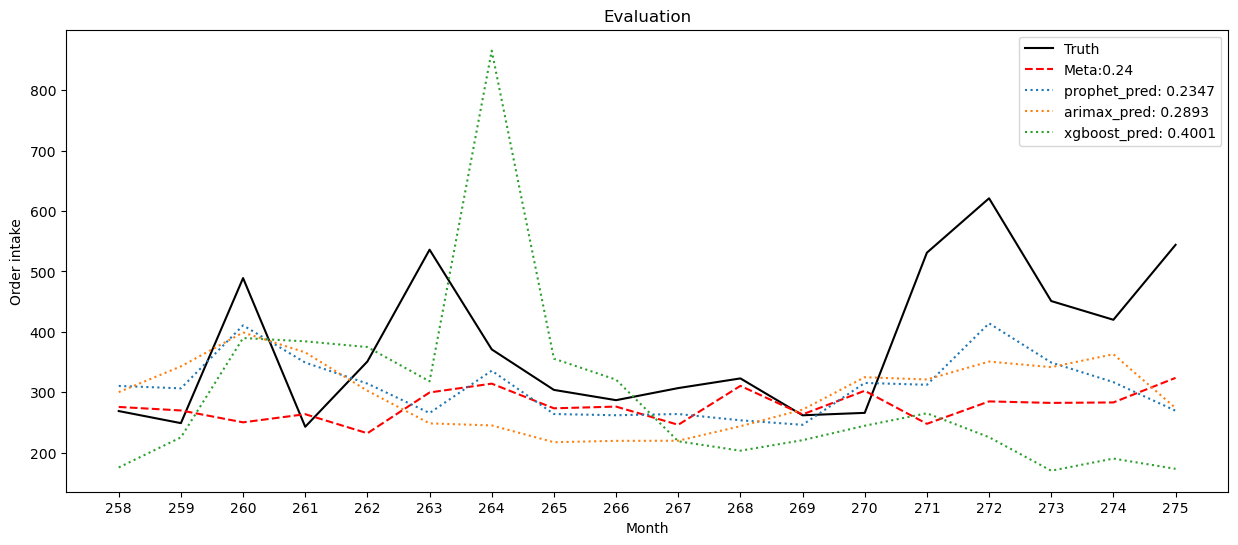

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

class MetaModel(Model):
    def __init__(self, data_block, predict_periods=TEST_PERIOD) -> None:
        super().__init__(data_block)
        self.data_block = data_block
        self.predict_periods = predict_periods
        self.preprocessing()
        # self.metamodel = xgboost.XGBRegressor(use_label_encoder=False, eval_metric="mape")
        self.metamodel = RandomForestRegressor()

    def preprocessing(self):
        """
        Split the train data into half: submodel and metadata
        """
        self.half_data_index = int(len(self.train_data)/2)
        self.meta_half_data_index = round(self.half_data_index/self.predict_periods) * self.predict_periods

        # 2nd half
        self.y_metadata = self.y_train.iloc[-self.meta_half_data_index:]

    def train_predict_submodel(self, input_data) -> pd.DataFrame:
        """
            Train all submodels and make predictions
        """
        self.prophet_model = ProphetModel(input_data)
        self.arimax_model = SARIMAXModel(input_data, exo=False)
        self.xgboost_model = XGBoostModel(input_data)

        self.prophet_model.train()
        self.arimax_model.train()
        self.xgboost_model.train()
            
        prophet_pred = self.prophet_model.predict()
        arimax_pred = self.arimax_model.predict()
        xgboost_pred = self.xgboost_model.predict()

        submodel_predictions = pd.DataFrame({
            "prophet_pred": prophet_pred,
            "arimax_pred": arimax_pred,
            "xgboost_pred": xgboost_pred
        })

        return submodel_predictions

    def train(self):
        # Train sub-models and use prediction of sub-models for meta model
        list_submodel_predictions = []
        submodel_data_index = self.half_data_index

        # Sequentially adding more data to train submodels until we make prediction for the whole second half of the data
        while submodel_data_index < len(self.y_train):
            train_submodel_data = self.train_data.iloc[:submodel_data_index, :]
            val_submodel_data = self.train_data.iloc[submodel_data_index:submodel_data_index+self.predict_periods, :]
            data_block_submodel = {
                "train": train_submodel_data,
                "val": val_submodel_data
            }

            submodel_predictions_df = self.train_predict_submodel(data_block_submodel)
            list_submodel_predictions.append(submodel_predictions_df)
            submodel_data_index += self.predict_periods

        # Train meta model
        # Create the dataset to train the meta model
        metadata_input = pd.concat(list_submodel_predictions, axis=0, sort=False)
        target = self.y_metadata
        
        # self.metamodel.fit(metadata_input, target)
        # Grid Search
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 5, 10],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
        grid_search = GridSearchCV(
            estimator=RandomForestRegressor(),
            param_grid=param_grid,
            scoring='neg_mean_absolute_percentage_error',
            cv=5
        )
        grid_search.fit(metadata_input, target)
        self.metamodel = RandomForestRegressor(**grid_search.best_params_)
        self.metamodel.fit(metadata_input, target)

        # score of 4 models
        # list_submodel_predictions
        # meta_score = mean_absolute_percentage_error(target.tolist(), submodel_pred)
        # self.metamodel.score()

    def predict(self, submodel_pred=False):
        submodel_predictions_df = self.train_predict_submodel(self.data_block)
        final_prediction = self.metamodel.predict(submodel_predictions_df).tolist()
        if submodel_pred:
            return final_prediction, submodel_predictions_df
        else:
            return final_prediction
    
    def run_eval(self, verbose=True) -> float:
        print("Training metamodel...")
        self.train()

        if self.y_val.isna().any().any():
            raise RuntimeError("No label data to evaluate.")

        print("\nEvaluating...")
        y_true = self.y_val.tolist()
        y_pred, submodel_predictions_df = self.predict(submodel_pred=True)
        mape = mean_absolute_percentage_error(y_true, y_pred)

        if verbose:
            plt.figure(figsize=(15,6))
            x_ticks = range(TEST_INDEX, TEST_INDEX+TEST_PERIOD)
            plt.plot(x_ticks, y_true, color="black", label="Truth")
            plt.plot(x_ticks, y_pred, color="red", linestyle="--", label=f"Meta:{mape:.2f}")
            for method in submodel_predictions_df.columns:
                submodel_pred = submodel_predictions_df[method].tolist()
                submodel_mape = mean_absolute_percentage_error(y_true, submodel_pred)
                plt.plot(x_ticks, submodel_pred, linestyle=":", label=f"{method}: {submodel_mape:.4f}")
            
            plt.xticks(x_ticks)
            plt.legend()
            plt.xlabel("Month")
            plt.ylabel("Order intake")
            plt.title(f"Evaluation")
            plt.show() 

meta_model = MetaModel(dev_set_meta)
meta_model.run_eval()

# Inference on unseen data, i.e train with all dataset to make the final prediction

In [15]:
# prod_set = prod_set.fillna(0)
train_prod_set = prod_set.iloc[:-TEST_PERIOD, :]
val_prod_set = prod_set.iloc[-TEST_PERIOD:, :]
prod_set_meta = {"train": train_prod_set, "val": val_prod_set}
meta_model = MetaModel(prod_set_meta)

meta_model.train()
y_pred, submodel_predictions_df = meta_model.predict(submodel_pred=True)

17:43:37 - cmdstanpy - INFO - Chain [1] start processing


17:43:37 - cmdstanpy - INFO - Chain [1] done processing



Preprocessing data...

Preprocessing data...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1523.924, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1503.173, Time=0.08 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1487.338, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1521.928, Time=0.00 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1487.296, Time=0.03 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1486.888, Time=0.06 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=1486.778, Time=0.16 sec
 ARIMA(0,1,1)(3,0,0)[12] intercept   : AIC=1482.231, Time=1.91 sec
 ARIMA(0,1,1)(4,0,0)[12] intercept   : AIC=1479.500, Time=3.62 sec
 ARIMA(0,1,1)(5,0,0)[12] intercept   : AIC=1481.198, Time=5.39 sec
 ARIMA(0,1,1)(4,0,1)[12] intercept   : AIC=1481.300, Time=3.38 sec
 ARIMA(0,1,1)(3,0,1)[12] intercept   : AIC=1481.334, Time=3.12 sec
 ARIMA(0,1,1)(5,0,1)[12] intercept   : AIC=inf, Time=5.48 sec
 ARIMA(0,1,0)(4,0,0)[12] intercept   : AIC=15

17:45:12 - cmdstanpy - INFO - Chain [1] start processing
17:45:12 - cmdstanpy - INFO - Chain [1] done processing



Preprocessing data...

Preprocessing data...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1728.629, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1709.291, Time=0.09 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1694.250, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1726.633, Time=0.00 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1694.609, Time=0.03 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=1690.910, Time=0.15 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1693.513, Time=0.07 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=1692.622, Time=0.28 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=1692.630, Time=0.29 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=1693.440, Time=0.22 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=1692.112, Time=0.18 sec
 ARIMA(0,1,1)(2,0,2)[12] intercept   : AIC=1694.234, Time=0.44 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1721.403, Time=0.08 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : A

17:45:25 - cmdstanpy - INFO - Chain [1] start processing
17:45:25 - cmdstanpy - INFO - Chain [1] done processing



Preprocessing data...

Preprocessing data...
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1928.586, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1888.870, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1897.864, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2348.462, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=1894.797, Time=0.01 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=1888.954, Time=0.39 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=1892.087, Time=0.19 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=1890.428, Time=0.10 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=1891.306, Time=0.55 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=1922.014, Time=0.08 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=1889.870, Time=0.15 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=1889.707, Time=0.19 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=1896.437, Time=0.11 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept   : A

17:45:29 - cmdstanpy - INFO - Chain [1] start processing
17:45:29 - cmdstanpy - INFO - Chain [1] done processing



Preprocessing data...

Preprocessing data...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2184.810, Time=0.00 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2166.111, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2163.141, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2183.100, Time=0.00 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=2164.853, Time=0.04 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=2153.476, Time=0.17 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=2161.265, Time=0.07 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=2154.371, Time=0.32 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=2154.402, Time=0.38 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=2159.477, Time=0.18 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=2155.442, Time=0.19 sec
 ARIMA(0,1,1)(2,0,2)[12] intercept   : AIC=2156.124, Time=0.50 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=2169.115, Time=0.11 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : A

17:45:46 - cmdstanpy - INFO - Chain [1] start processing
17:45:46 - cmdstanpy - INFO - Chain [1] done processing



Preprocessing data...

Preprocessing data...
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2422.514, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=2375.777, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=2388.518, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2869.997, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=2382.241, Time=0.01 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=2372.139, Time=0.45 sec
 ARIMA(1,0,0)(3,0,0)[12] intercept   : AIC=2374.693, Time=2.58 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=2374.979, Time=0.53 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=2379.310, Time=0.20 sec
 ARIMA(1,0,0)(3,0,1)[12] intercept   : AIC=inf, Time=3.58 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=2416.118, Time=0.36 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=2372.297, Time=0.57 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=2372.521, Time=0.57 sec
 ARIMA(0,0,1)(2,0,0)[12] intercept   : AIC=23

17:45:58 - cmdstanpy - INFO - Chain [1] start processing
17:45:58 - cmdstanpy - INFO - Chain [1] done processing



Preprocessing data...

Preprocessing data...
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2670.906, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=2610.458, Time=0.16 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=2631.037, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=3138.320, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=2622.470, Time=0.02 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=2584.039, Time=0.47 sec
 ARIMA(1,0,0)(3,0,0)[12] intercept   : AIC=2586.045, Time=4.86 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=2593.386, Time=0.77 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=2616.088, Time=0.28 sec
 ARIMA(1,0,0)(3,0,1)[12] intercept   : AIC=inf, Time=4.06 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=2638.179, Time=0.40 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=2583.423, Time=0.58 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=2609.597, Time=0.22 sec
 ARIMA(2,0,0)(3,0,0)[12] intercept   : AIC=25

17:46:26 - cmdstanpy - INFO - Chain [1] start processing
17:46:26 - cmdstanpy - INFO - Chain [1] done processing



Preprocessing data...

Preprocessing data...
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2893.757, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=2821.629, Time=0.17 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=2845.965, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=3393.960, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=2833.786, Time=0.01 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=2793.539, Time=0.52 sec
 ARIMA(1,0,0)(3,0,0)[12] intercept   : AIC=2794.809, Time=5.46 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=2798.894, Time=0.61 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.32 sec


KeyboardInterrupt: 

In [ ]:
# SARIMAX_predictor = SARIMAXModel({"train": prod_set.iloc[:TEST_INDEX, :], "val": prod_set.iloc[TEST_INDEX:, :]})
# SARIMAX_predictor.train()
# arima_prediction = SARIMAX_predictor.predict()

# prophet_predictor = ProphetModel({"train": prod_set.iloc[:TEST_INDEX, :], "val": prod_set.iloc[TEST_INDEX:, :]})
# prophet_predictor.train()
# prophet_prediction = prophet_predictor.predict()

In [ ]:
# plt.figure(figsize=(12,5))
# current_demand = dev_set.loc[:, TARGET_COL_NAME].tolist()

# plt.plot(range(TEST_INDEX), current_demand, label="Current data")

# for method in submodel_predictions_df.columns:
#     pred = submodel_predictions_df[method].to_list()
#     print(f"Our {method} prediction:", pred, "\n")
#     plt.plot(range(TEST_INDEX-1, TEST_INDEX+TEST_PERIOD), [current_demand[-1]] + pred, linestyle="--", label=method)

# print("Metamodel prediction:", pred, "\n")
# plt.plot(range(TEST_INDEX-1, TEST_INDEX+TEST_PERIOD), [current_demand[-1]] + y_pred, linestyle="--", label="Metamodel")

# plt.xticks([0, TEST_INDEX, TEST_INDEX+TEST_PERIOD])
# plt.legend()
# plt.show()

Our prophet_pred prediction: [339.8956613610397, 282.4969234670846, 286.9527878463127, 289.22750271898866, 286.73204241549786, 281.37358717128427, 340.24649660365395, 342.42688179167675, 489.46713143904736, 398.124056461789, 365.32110732332836, 348.9020682582503, 349.64853897065984, 289.3242912907039, 292.3734815459266, 294.29477270830887, 291.9754279692263, 287.05491613238127] 

Our arimax_pred prediction: [391.11980708796625, 334.8166265029522, 290.83625126095086, 278.85059688914015, 296.22277531150485, 269.76367810901905, 287.60357712979925, 326.12185099781124, 429.0178656185038, 309.636351134027, 343.50373964269403, 432.5122525265517, 345.7108564834551, 311.47256963431664, 297.5973062141992, 302.7859304991654, 311.64663282098957, 284.8107654041279] 

Our xgboost_pred prediction: [182.75196838378906, 172.81890869140625, 224.19677734375, 461.6445617675781, 340.2141418457031, 257.65911865234375, 304.0668640136719, 331.35546875, 679.4508666992188, 330.2095642089844, 358.1643371582031, 

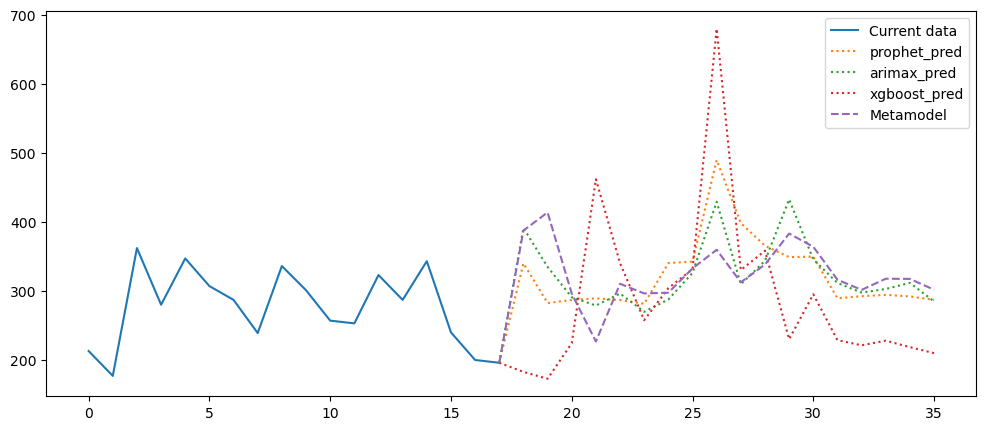

In [ ]:
plt.figure(figsize=(12,5))

current_demand = prod_set.loc[:, TARGET_COL_NAME].tolist()
last_18_demand = current_demand[-18:]
plt.plot(range(18), last_18_demand, label="Current data")

for method in submodel_predictions_df.columns:
    pred = submodel_predictions_df[method].to_list()
    print(f"Our {method} prediction:", pred, "\n")
    pred_vis = [last_18_demand[-1]] + pred
    plt.plot(range(17, 36), pred_vis, linestyle=":", label=method)

print("Metamodel prediction:", pred, "\n")
pred_vis = [last_18_demand[-1]] + y_pred
plt.plot(range(17, 36), pred_vis, linestyle="--", label="Metamodel")

plt.legend()
plt.show()

In [ ]:
# num_cols = 4
# num_rows = 5

# plt.figure(figsize=(20, 10))
# for i, col in enumerate(missing_data_summary.index):
#     plt.subplot(num_rows, num_cols, i + 1)
#     sns.histplot(tiny_data[col], color="lightblue") # drop na values only when visualize

#     mean_val = tiny_data[col].mean()
#     median_val = tiny_data[col].median()
    
#     # Add vertical lines for mean and median
#     plt.axvline(x=mean_val, color='red', linestyle='--', linewidth=3, label='Mean')
#     plt.axvline(x=median_val, color='black', linestyle='--', linewidth=3, alpha=.7, label='Median')

#     plt.xlabel("")
#     plt.title(col + f" ({int(missing_data_summary.loc[col, 'missing_per'])}% NA)", fontsize=10)

# plt.tight_layout()
# plt.suptitle("Distrubtion plot of variable", fontsize=16)
# plt.subplots_adjust(top=0.9)
# plt.legend()
# plt.show()

In [ ]:
# num_cols = 4
# num_rows = 5

# plt.figure(figsize=(20, 10))
# for i, col in enumerate(missing_data_summary.index):
#     plt.subplot(num_rows, num_cols, i + 1)
#     sns.lineplot(tiny_data[col], color="lightblue") # drop na values only when visualize

#     mean_val = tiny_data[col].mean()
#     median_val = tiny_data[col].median()
    
#     # Vertical line for missing position
#     missing_indices = tiny_data[col][tiny_data[col].isnull()].index
#     plt.axvline(x=missing_indices[0], color='green', linestyle=':', linewidth=0.7, label="Missing")
#     for missing_index in missing_indices[1:]:
#         plt.axvline(x=missing_index, color='green', linestyle=':', linewidth=0.7)  

#     # Add vertical lines for mean and median
#     plt.axhline(y=mean_val, color='red', linestyle='--', linewidth=3, label='Mean')
#     plt.axhline(y=median_val, color='black', linestyle='--', linewidth=3, alpha=.7, label='Median')

#     plt.ylabel("")
#     plt.title(col + f" ({int(missing_data_summary.loc[col, 'missing_per'])}% NA)", fontsize=10)

# plt.tight_layout()
# plt.suptitle("Time series plot of variable", fontsize=16)
# plt.subplots_adjust(top=0.9)
# plt.legend(loc='lower right', bbox_to_anchor=(2, 0), ncol=1)
# plt.show()

### Check for autocorrelation

In [ ]:
# from matplotlib import pyplot
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# plot_acf(target.diff(12).dropna(), lags=50)
# plot_pacf(target.diff(12).dropna(), lags=50)
# pyplot.show()

# from statsmodels.tsa.stattools import adfuller
# from numpy import log
# result = adfuller(target.dropna())
# print('ADF Statistic: %f' % result[0])
# print('p-value: %f' % result[1])

In [ ]:
# from statsmodels.tsa.seasonal import seasonal_decompose

# result = seasonal_decompose(target.dropna(), model='additive', period=12)
# plt.figure(figsize=(20,6))
# result.plot()
# plt.show()

In [ ]:
# from sklearn.inspection import permutation_importance
# from xgboost import XGBRegressor
# from sklearn.model_selection import TimeSeriesSplit

# tscv = TimeSeriesSplit(n_splits=4, gap=6, test_size=18)

# non_na_data = tiny_data.dropna()
# X_in = non_na_data.drop("sales_actuals_monthly__orderintake", axis=1)
# y = non_na_data["sales_actuals_monthly__orderintake"]

# importances_mean = []
# importances_std = []
# for i, (train_index, test_index) in enumerate(tscv.split(X_in, y)):
#     print(train_index, test_index)
#     X_train, y_train = X_in.iloc[train_index], y.iloc[train_index]
#     X_val, y_val = X_in.iloc[test_index], y.iloc[test_index]
#     model = XGBRegressor().fit(X_train, y_train)
#     result = permutation_importance(
#         model,
#         X_val,
#         y_val,
#         n_repeats=10,
#         scoring='neg_mean_absolute_error', # neg_mean_absolute_percentage_error
#         random_state=0
#     )

#     importances_mean.append(result.importances_mean)
#     importances_std.append(result.importances_std)

In [ ]:
# feature_importance_df = pd.Series(np.mean(importances_mean, axis=0), index=X_in.columns).sort_values(ascending=True)
# feature_importance_df.plot.barh()
# plt.title("Permutation importance (the larger the better)")
# plt.xlabel("Decrease in MAE score")
# plt.plot()

In [ ]:
# vehicle_group_list = [f'{i:02}' for i in range(1, 65)]
# country_list = [f'Country {name}' for name in ['A', 'B', 'C', 'D']]
# print(vehicle_group_list)
# print(country_list)

In [ ]:
# in_correlation = X_in.corrwith(y)
# print(in_correlation[abs(in_correlation) > 0.39])
# colors = ['red' if abs(val) > 0.39 else 'grey' for val in in_correlation]
# ax = in_correlation.plot.barh(color=colors)
# ax.axvline(x=0.39, color='black', linestyle='dotted')
# ax.set_xticks([0.39])
# yticks = ax.get_yticklabels()
# ytick_labels = [label.get_text().replace("__vehiclegroup01__", "_") for label in yticks]
# ax.set_yticklabels(ytick_labels)
# plt.show()

## External features

In [ ]:
# X_ex = external_data.iloc[non_na_data.index,:].drop(columns=['month'])

# importances_mean = []
# importances_std = []
# for i, (train_index, test_index) in enumerate(tscv.split(X_ex, y)):
#     print(train_index, test_index)
#     X_train, y_train = X_ex.iloc[train_index], y.iloc[train_index]
#     X_val, y_val = X_ex.iloc[test_index], y.iloc[test_index]
#     model = XGBRegressor().fit(X_train, y_train)
#     result = permutation_importance(
#         model,
#         X_val,
#         y_val,
#         n_repeats=10,
#         scoring='neg_mean_absolute_error', # neg_mean_absolute_percentage_error
#         random_state=0
#     )

#     importances_mean.append(result.importances_mean)
#     importances_std.append(result.importances_std)

# feature_importance_df = pd.Series(np.mean(importances_mean, axis=0), index=X_ex.columns).sort_values(ascending=True)[:20]
# feature_importance_df.plot.barh()
# plt.title("Permutation importance (the larger the better)")
# plt.xlabel("Decrease in MAE score")
# plt.plot()

In [ ]:
# ex_correlation = X_ex.corrwith(y)
# plt.figure(figsize=(15, 6))
# ex_correlation.plot.box(vert=False)
# plt.show()

The middle 50% of the data (interquartile range) has value smaller quite small. We visualize only features with correlation larger than +-0.4

In [ ]:
# large_corr_ex_features = ex_correlation[abs(ex_correlation) > 0.4]
# print(large_corr_ex_features)

In [ ]:
# plt.barh(large_corr_ex_features.index, large_corr_ex_features.values)
# plt.show()

## Visualize number of features for each vehicle group

In [ ]:
# vec_dict = {}
# for veh in vehicle_group_list:
#     vec_dict[veh] = len(internal_data.filter(regex=f"vehiclegroup{veh}").columns)

# df_temp = pd.DataFrame(vec_dict.items(), columns=['Vehicle group', 'No. of features'])

# plt.figure(figsize=(14, 7), facecolor='white')
# colors = ['red' if i in [49, 52, 55] else 'grey' for i in range(1, len(df_temp)+1)]
# colors[:6] = ["lightblue"] * 6
# plt.bar(df_temp['Vehicle group'], df_temp['No. of features'], color=colors, edgecolor='none')
# plt.axhline(y=5, xmax=0.82, color='black', linestyle='dotted')

# plt.xlabel('Vehicle group', fontsize=15)
# plt.ylabel('No. of features', fontsize=15)
# plt.title('Number of features for each vehicle group', fontsize=25)
# plt.xticks(["01", "06"] + ["49", "52", "55"], fontsize=10)
# plt.yticks([5,15,18], fontsize=15)
# plt.tight_layout()
# plt.box(False)
# plt.savefig("../img/vehicle_vs_internal_features.png", bbox_inches='tight')
# plt.show()